### Real/Fake-FaceDetection

In [1]:
real = '../real_and_fake_face/training_real/'
fake = '../real_and_fake_face/training_fake/'

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing

In [3]:
import os
real_path = os.listdir(real)
fake_path = os.listdir(fake)

In [4]:
import cv2
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224, 224))
    return image[...,::-1]

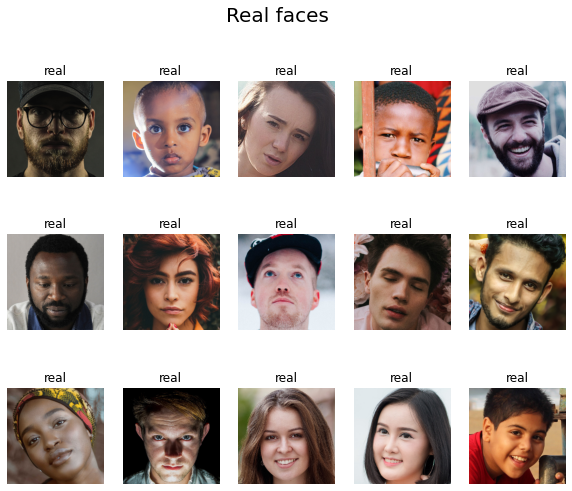

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 8))

for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(load_img(real + real_path[i]))
    plt.suptitle("Real faces",fontsize=20)
    plt.title(real_path[i][:4])
    plt.axis('off')

plt.show()

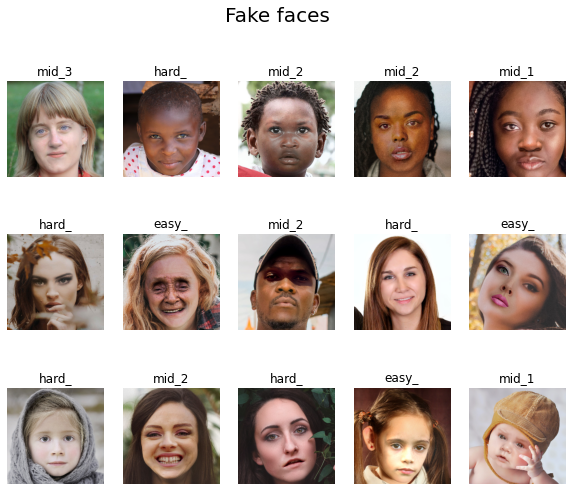

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 8))

for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(load_img(fake + fake_path[i]))
    plt.suptitle("Fake faces",fontsize=20)
    plt.title(fake_path[i][:5])
    plt.axis('off')

plt.show()

In [7]:
import tensorflow
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
data_with_aug = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1./255,
                                  validation_split=0.2)

In [8]:
dataset_path = "/kaggle/input/real-and-fake-face-detection/real_and_fake_face"
train = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=98,
                                          subset="training")

test = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=98,
                                          subset="validation"
                                          )

Found 1633 images belonging to 2 classes.
Found 408 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image

# re-size all the images to this IMAGE_SIZE = [224, 224, 3]

# add preprocessing layer to the front of VGG
vgg16_model = tensorflow.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

In [10]:
vgg16_model.output[-1]

<KerasTensor: shape=(7, 7, 512) dtype=float32 (created by layer 'tf.__operators__.getitem')>

In [11]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# output layers - you can add more if you want
model = tensorflow.keras.Sequential([vgg16_model,
                    Flatten(),
                    Dense(2, activation = "softmax")])

# don't train existing weights
# for layer in vgg16_model:
#   layer.trainable = False
model.layers[0].trainable = False

# tell the model what cost and optimization method to use
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

# view the structure of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 50178     
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


In [13]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001 
    else:
        return 0.00001

lr_callbacks = tensorflow.keras.callbacks.LearningRateScheduler(scheduler)

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
hist =  model.fit(train,
                    epochs=3,
                    callbacks=[lr_callbacks],
                    validation_data=test)

# fit the model
# r = model.fit(train,validation_data=test, epochs=5, steps_per_epoch=len(train), validation_steps=len(test))

2021-10-30 08:21:02.601595: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3
17/17 [==============================] - 538s 32s/step - loss: 1.4528 - accuracy: 0.5193 - val_loss: 1.2753 - val_accuracy: 0.5319
Epoch 2/3
17/17 [==============================] - 532s 32s/step - loss: 0.8450 - accuracy: 0.6234 - val_loss: 0.9755 - val_accuracy: 0.5098
Epoch 3/3
17/17 [==============================] - 530s 31s/step - loss: 0.5818 - accuracy: 0.7140 - val_loss: 0.8900 - val_accuracy: 0.5294


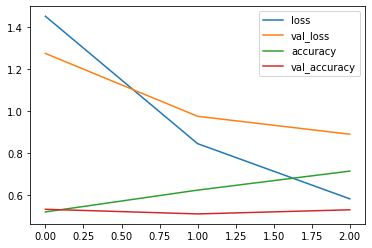

<Figure size 432x288 with 0 Axes>

In [15]:
# loss
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
# accuracy
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()
plt.savefig('LossVal_loss&AccVal_acc')

In [16]:
# Predictions
# useful for getting number of classes
# folders = glob('Datasets/Train/*')
# prediction = Dense(len(folders), activation='softmax')(x)

predictions = model.predict(test)

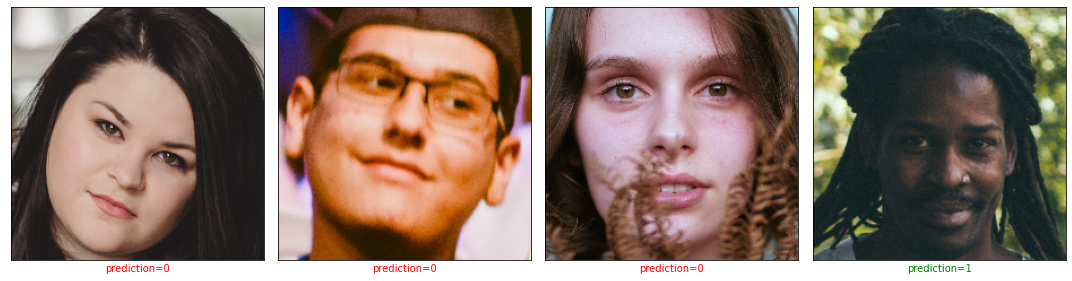

In [17]:
val_path = "/kaggle/input/real-and-fake-face-detection/real_and_fake_face/"

plt.figure(figsize=(15,15))

start_index = 250

for i in range(4):
    plt.subplot(1,4, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
  
    preds = np.argmax(predictions[[start_index+i]])
    
    te = test.filenames[start_index+i][9:13]

  
    if te == "fake":
        te = 0
    else:
        te = 1
    
    if preds != te:
        col ="r"
    else:
        col = "g"

    plt.xlabel('prediction={}'.format(preds),color=col)
    plt.imshow(load_img(val_path+test.filenames[start_index+i]))
    plt.tight_layout()

plt.show()

In [18]:
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [19]:
mnet = tensorflow.keras.applications.MobileNetV2(include_top = False, weights = "imagenet" ,input_shape=(224,224,3))
# MobileNets support any input size greater than 32 x 32, with larger image sizes offering better performance.

9420800/9406464 [==============================] - 0s 0us/step


In [20]:
tensorflow.keras.backend.clear_session()
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout

model = tensorflow.keras.Sequential([mnet,
                    GlobalAveragePooling2D(),
                    Dense(512, activation = "relu"),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(128, activation = "relu"),
                    Dropout(0.1),
                    # Dense(32, activation = "relu"),
                    # Dropout(0.3),
                    Dense(2, activation = "softmax")])

model.layers[0].trainable = False

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [21]:
hist =  model.fit(train,
                    epochs=3,
                    callbacks=[lr_callbacks],
                    validation_data=test)

Epoch 1/3
17/17 [==============================] - 50s 3s/step - loss: 0.9889 - accuracy: 0.5683 - val_loss: 0.9730 - val_accuracy: 0.5343
Epoch 2/3
17/17 [==============================] - 45s 3s/step - loss: 0.6003 - accuracy: 0.6981 - val_loss: 0.7906 - val_accuracy: 0.5221
Epoch 3/3
17/17 [==============================] - 45s 3s/step - loss: 0.5013 - accuracy: 0.7587 - val_loss: 0.8507 - val_accuracy: 0.4853


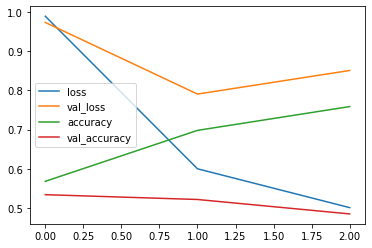

<Figure size 432x288 with 0 Axes>

In [22]:
# loss
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
# accuracy
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()
plt.savefig('LossVal_loss&AccVal_acc')

                                                                                                                Dhanya Jayan